<a href="https://colab.research.google.com/github/ani98622/NLP-assignments/blob/main/AniketMDS202308_Assignment2%263.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Name : Aniket Tiwari
- Roll No. MDS202308


### Assignment - 02


- Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import h5py
import re
import json
import nltk
from scipy.sparse import save_npz
from scipy.sparse import csr_matrix
from nltk import ngrams
from tqdm import tqdm
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

- Extracting Vocabulary to choose most frequent 7000 words

In [ ]:
def process_file(file_path):
    word_counter = Counter()
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line_words = line.strip().split()
            word_counter.update(line_words)
    return word_counter

In [ ]:
file_path = '/content/drive/MyDrive/processed_words.txt'
word_frequencies = process_file(file_path)

In [ ]:
vocabulary = word_frequencies.most_common(7000)
vocab = [word for word, freq in vocabulary]

print(f"Total unique words: {len(word_frequencies)}")
print(f"Size of vocabulary: {len(vocab)}")
print(f"Most common words: {word_frequencies.most_common(10)}")

Total unique words: 7000
Size of vocabulary: 7000
Most common words(TOP 6): ['patients', 'cells', 'also', 'covid19', 'study', 'data']


- Construction of co-occurrence_matrix

In [ ]:
from nltk import word_tokenize
from tqdm import tqdm
from scipy.sparse import dok_matrix
from collections import defaultdict, Counter

vocab_idx = {word: idx for idx, word in enumerate(vocab)}

def co_occurrences(file_path):
    window_size = 4
    ramp = [0] + list(range(window_size, 0, -1))   # ramp = [0,4,3,2,1]
    occurrences_tracker = defaultdict(lambda: Counter())

    with open(file_path, 'r', encoding="utf-8") as files:
        for line in files:
            all_n_grams = ngrams(word_tokenize(line), window_size + 1, pad_right=True, pad_left=True)
            for n_gram in all_n_grams:
                if n_gram[0] in vocab:
                    for idx, gram in enumerate(n_gram):
                        if gram in vocab:
                            occurrences_tracker[vocab_idx[n_gram[0]]][vocab_idx[gram]] += ramp[idx]

                reversed_n_gram = n_gram[::-1]
                if reversed_n_gram[0] in vocab:
                    for idx, gram in enumerate(reversed_n_gram):
                        if gram in vocab:
                            occurrences_tracker[vocab_idx[reversed_n_gram[0]]][vocab_idx[gram]] += ramp[idx]

    sparse_matrix = dok_matrix((len(vocab), len(vocab)), dtype=np.int64)

    # Populate the matrix
    for current_i in tqdm(range(len(vocab))):
        for current_j in occurrences_tracker[current_i].keys():
            sparse_matrix[current_i, current_j] = occurrences_tracker[current_i][current_j]

    return sparse_matrix.tocsr()

- Save the Output Frequency Matrix to avoid memory crash

In [ ]:
freq_mat = co_occurrences('/content/drive/MyDrive/processed_words.txt')
save_path = '/content/drive/MyDrive/Assign/cooccurrence_matrix.npz'
save_npz(save_path, freq_mat)

print(f"Matrix saved successfully at {save_path}")

Matrix saved successfully at /content/drive/MyDrive/Assign/cooccurrence_matrix.npz


- Calling saved matrix stored in drive

In [ ]:
data = np.load('/content/drive/MyDrive/Assign/cooccurrence_matrix.npz')
matrix = csr_matrix((data['data'], data['indices'], data['indptr']), shape=data['shape'])

freq_mat = matrix.toarray()

vocab_subset = vocab[3000:3015]
df = pd.DataFrame(freq_mat[3000:3015, 3000:3015], index=vocab_subset, columns=vocab_subset)
print("\t\t\t\tSubset of Co-occurrence Matrix as DataFrame:")
df

				Subset of Co-occurrence Matrix as DataFrame:


,infant,connection,mammals,chemokines,tertiary,validity,official,yielded,blocks,reveals,statement,routinely,deposition,breath,spaces
infant,652,4,5,1,1,0,0,4,0,0,1,8,0,0,6
connection,4,494,12,2,0,2,5,3,27,31,10,0,4,2,17
mammals,5,12,246,0,4,0,0,2,2,11,5,1,8,0,5
chemokines,1,2,0,626,3,0,0,0,3,4,0,0,4,0,5
tertiary,1,0,4,3,136,1,1,5,9,10,0,1,0,1,0
validity,0,2,0,0,1,832,9,4,7,0,11,6,0,0,0
official,0,5,0,0,1,9,280,3,4,11,127,5,0,0,10
yielded,4,3,2,0,5,4,3,144,0,0,1,12,0,0,3
blocks,0,27,2,3,9,7,4,0,734,5,5,12,11,0,1
reveals,0,31,11,4,10,0,11,0,5,12,6,0,29,23,15


- Amount of sparsity in 'freq_mat'

In [ ]:
total_elements = freq_mat.shape[0] * freq_mat.shape[1]
non_zero_elements = matrix.count_nonzero()

sparsity = 1 - (non_zero_elements / total_elements)

print(f"Sparsity of the matrix: {sparsity*100:.2f}%")

Sparsity of the matrix: 41.06%


<h2 align="center" > Methodology :</h2>
<br>
We define the probability $ P{_{ij}} $ as :

$$
P(j \mid i) = \frac{X_{ij}}{X_i}
$$
where ${X_{ij}}$ represents the frequency of word k in context of word $ i $ and ${X_i}$ is the no. of times word $ i $ appeared with any other word.<br> Thus, $P(j \mid i)$  represents the probability that word  $ j $  appears in the context of word $ i $.

$$
\frac{P{_{ik}}}{P{_{jk}}} = \frac{P(k \mid i)}{P(k \mid j)} = \frac{X_{ik} \cdot X_j}{X_{jk} \cdot X_i}
$$

This compares how frequently word $ k $ appears in the context of word $ i $ relative to word $ j $ where the numerator and denominator account for the total co-occurrence counts of word $ k $ with words $ i $ and $ j $, weighted by their respective total context occurrences.

`Note` : The `k` is chosen dynamically for each $j$ based on the row-wise maximum of the `weight_mat`. This strategy ensures that for each $ j $ , the co-occurrence value is computed relative to the most influential (highest weighted) feature k in that row.

- Weighted Frequency Matrix & Co-occurence Matrix

In [ ]:
def calc_weight_mat(dim,freq_mat):
  weight_mat = np.zeros((dim, dim),dtype=float)
  row_sums = np.sum(freq_mat, axis=1)

  for i in tqdm(range(dim)):
      weight_mat[i,:] = freq_mat[i,:]/row_sums[i]
  return weight_mat

def calc_co_occur_mat(dim,weight_mat):
  co_mat = np.zeros((dim, dim),dtype=float)
  for j in tqdm(range(dim)):
    k = np.argmax(weight_mat[j,:])  # Method to chose 'k'
    for i in range(dim):
      num = weight_mat[i, k]
      deno = weight_mat[j, k]
      if deno != 0:
        co_mat[i, j] = num/deno
  return co_mat

- Similarity Calculation

In [ ]:
def cosine_sim(vec_a, vec_b):
  dot_product = np.dot(vec_a, vec_b)
  norm_a = np.linalg.norm(vec_a)
  norm_b = np.linalg.norm(vec_b)
  if norm_a == 0 or norm_b == 0:
      return 0
  return dot_product / (norm_a * norm_b)

def find_similar_words(co_mat, word, top_n=10):
    index = vocab_idx[word]
    word_vector = co_mat[index]
    similarities = []
    for i in range(co_mat.shape[0]):
        if i != index:
            sim = cosine_sim(word_vector, co_mat[i])
            similarities.append((vocab[i], sim))

    similarities.sort(key=lambda x: x[1], reverse=True)
    top_similar_words = similarities[:top_n]

    return top_similar_words

- Vocabulary size & size of matrix

In [ ]:
print('Vocabulary Size :', len(vocab))
print('Cooccurence Matrix Size :', freq_mat.shape)

Vocabulary Size : 7000
Cooccurence Matrix Size : (7000, 7000)


- Calling Functions to form Weighted Matrix & Co-occurence Matrix

In [ ]:
dim = freq_mat.shape[0]
weight_mat = calc_weight_mat(dim,freq_mat)

100%|██████████| 7000/7000 [00:00<00:00, 15123.05it/s]


In [ ]:
co_occur_mat = calc_co_occur_mat(dim,weight_mat)

100%|██████████| 7000/7000 [01:14<00:00, 93.36it/s] 


### Assignment - 03

- 5 nouns and verbs relavant to covid-19 data

In [ ]:
nouns =  ['virus','pathogen','symptoms','lockdown','transmission']
verbs = ['spread','infect','isolate','diagnose','monitor']

In [ ]:
def print_similar_words(co_mat, words):
    for word in words:
        top_similar_words = find_similar_words(co_mat, word)

        print(f"\nTop similar words to '{word}':")
        print("-" * (len(f"Top similar words to '{word}':")))

        for idx, (similar_word, similarity) in enumerate(top_similar_words, start=1):
            cosine_distance = 1 - similarity
            print(f"{idx}. {similar_word:<20} (Cosine Distance: {cosine_distance:.4f})")


- 10 similar words each for 5 verbs

In [ ]:
print_similar_words(co_occur_mat, nouns)


Top similar words to 'virus':
-----------------------------
1. hsv1                 (Cosine Distance: 0.0524)
2. poliovirus           (Cosine Distance: 0.0657)
3. ebov                 (Cosine Distance: 0.0671)
4. hsv2                 (Cosine Distance: 0.0696)
5. reovirus             (Cosine Distance: 0.0699)
6. fipv                 (Cosine Distance: 0.0699)
7. denv                 (Cosine Distance: 0.0728)
8. hiv1                 (Cosine Distance: 0.0764)
9. bvdv                 (Cosine Distance: 0.0784)
10. norovirus            (Cosine Distance: 0.0813)

Top similar words to 'pathogen':
--------------------------------
1. pathogens            (Cosine Distance: 0.0829)
2. possibility          (Cosine Distance: 0.0999)
3. organism             (Cosine Distance: 0.1061)
4. consequence          (Cosine Distance: 0.1112)
5. supposed             (Cosine Distance: 0.1131)
6. likewise             (Cosine Distance: 0.1162)
7. occurs               (Cosine Distance: 0.1187)
8. probably          

- 10 similar words each for 5 verbs

In [ ]:
print_similar_words(co_occur_mat,verbs)


Top similar words to 'spread':
------------------------------
1. spreading            (Cosine Distance: 0.0232)
2. spreads              (Cosine Distance: 0.0619)
3. caused               (Cosine Distance: 0.0779)
4. deadly               (Cosine Distance: 0.0963)
5. transmission         (Cosine Distance: 0.1046)
6. emergence            (Cosine Distance: 0.1114)
7. combat               (Cosine Distance: 0.1376)
8. coronavirus          (Cosine Distance: 0.1429)
9. transmissibility     (Cosine Distance: 0.1442)
10. emerged              (Cosine Distance: 0.1454)

Top similar words to 'infect':
------------------------------
1. kill                 (Cosine Distance: 0.0328)
2. lineage              (Cosine Distance: 0.0356)
3. replicate            (Cosine Distance: 0.0376)
4. propagated           (Cosine Distance: 0.0402)
5. preferentially       (Cosine Distance: 0.0409)
6. grow                 (Cosine Distance: 0.0423)
7. enter                (Cosine Distance: 0.0424)
8. passages            

- Visualization of Concepts

In [ ]:
concept_3 = ['lockdown', 'confinement', 'restrictions', 'reopening', 'outbreak','epidemic']
concept_1 =  ['virus', 'hsv1', 'poliovirus', 'ebov', 'mutation' , 'flavivirus']
concept_2 = ["symptoms", "patients", "mortality", "recovery", "comorbidity",'oxygen']

- Function to compute similar matrix

In [ ]:
def compute_sim_mat(concept_1,concept_2,concept_3):
  final_words = concept_1 + concept_2 + concept_3
  len_words = len(final_words)
  similarity_mat = np.ones((len_words,len_words),dtype=float)

  for i in range(len_words):
    for j in range(len_words):
      if i != j:
        similarity_mat[i,j] = cosine_sim(co_occur_mat[vocab_idx[final_words[i]]],co_occur_mat[vocab_idx[final_words[j]]])
  return similarity_mat,final_words

In [ ]:
similarity_mat, keywords = compute_sim_mat(concept_1,concept_2,concept_3)

In [ ]:
concepts = {
    'Viruses and Mutations':concept_1,
    'Health Impact': concept_2,
    'Pandemic and Containment Measures': concept_3
}

color_map = {
    'Viruses and Mutations' : 'blue',
    'Health Impact' : 'green',
    'Pandemic and Containment Measures' : 'red'
}

colors = []
for keyword in keywords:
    for concept, words in concepts.items():
        if keyword in words:
            colors.append(color_map[concept])
            break

- Using MDS library of Python

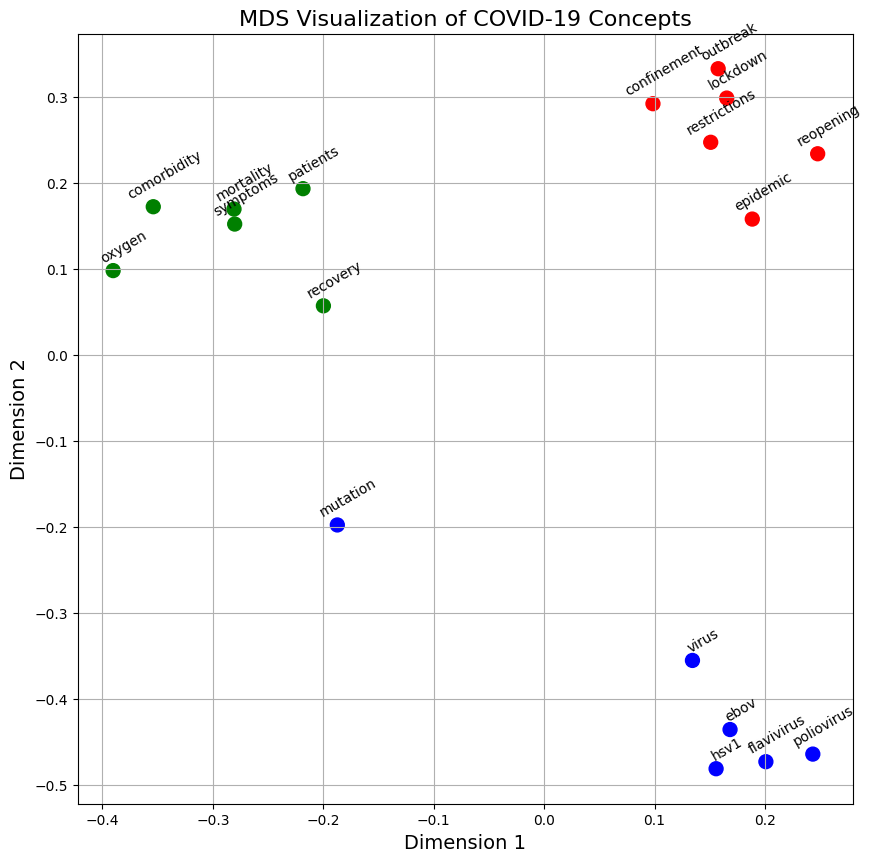

In [ ]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1, normalized_stress='auto')
coords = mds.fit_transform(1 - similarity_mat)
plt.figure(figsize=(10, 10))
plt.scatter(coords[:, 0], coords[:, 1], color=colors, s=100)

for i, keyword in enumerate(keywords):
    x_offset = 0.01
    y_offset = 0.01
    plt.annotate(keyword, (coords[i, 0] + x_offset, coords[i, 1] + y_offset),
                 fontsize=10, ha='center', rotation=30)  # Rotate text by 30 degrees

plt.title('MDS Visualization of COVID-19 Concepts', fontsize=16)
plt.xlabel('Dimension 1', fontsize=14)
plt.ylabel('Dimension 2', fontsize=14)
plt.grid(True)
plt.show()
